In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from tqdm import tqdm
import optuna
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

### Load Data

In [3]:
ratings = pd.read_csv("./ratings.csv")
data = ratings.iloc[:, : -1]

In [4]:
# --- Extract year from movie title ---
def extract_year(title):
    """Extract 4-digit year from movie title in parentheses."""
    if m := re.search(r'\((\d{4})\)', title):
        return int(m.group(1))
    return None


# --- Load movies data ---
movies = pd.read_csv("movies.csv")

# Extract year and compute decade
movies['year'] = movies['title'].map(extract_year)
movies['decade'] = ((movies['year'] // 10) * 10).astype('Int64')
movies['decade'] = movies['decade'].astype('string') + "s"
movies.loc[movies['year'] < 1950, 'decade'] = 'pre 1950s'

# Map movie IDs to titles
movieid_to_title = dict(zip(movies['movieId'], movies['title']))

# Clean genres
movies['genres'] = movies['genres'].str.split('|').apply(
    lambda lst: [g for g in lst if g != '(no genres listed)']
)

# Ensure decade is string and handle missing values
movies['decade'] = movies['decade'].astype('string')
movies['decade'] = movies['decade'].where(movies['decade'].notna(), None)

# Select relevant columns
movies = movies[['movieId', 'title', 'genres', 'decade']]

# Fill missing decade for encoding
movies['decade_filled'] = movies['decade'].fillna('SKIP_THIS')


# --- Encode features ---
# Multi-hot encode genres
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(movies['genres'])

# One-hot encode decades
valid_decades = sorted([d for d in movies['decade_filled'].dropna().unique() if d != 'SKIP_THIS'])
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories=[valid_decades])
decade_features = ohe.fit_transform(movies[['decade_filled']])

# Combine genre and decade features
item_features = np.hstack([genre_features, decade_features])

# Feature names
decade_feature_names = [f"decade_{d}" for d in valid_decades]
genre_feature_names = [f"genre_{g}" for g in mlb.classes_]
feature_names = genre_feature_names + decade_feature_names

### Split into train and test

In [5]:
# --- Users ---
max_users = np.max(data.iloc[:, 0])
unique_users_ordered = pd.unique(data.iloc[:, 0])[:max_users]

# Filter data to only include these users
filtered_data = data[data.iloc[:, 0].isin(unique_users_ordered)].copy()

# Remap user IDs to 0-based indexing
user_id_map = {old: new for new, old in enumerate(unique_users_ordered)}
filtered_data.iloc[:, 0] = filtered_data.iloc[:, 0].map(user_id_map)

# --- Items ---
unique_items = filtered_data.iloc[:, 1].unique()
item_id_map = {old: new for new, old in enumerate(unique_items)}

# Filter movies to include only these items and map new item indices
movies = movies[movies['movieId'].isin(item_id_map)].copy()
movies['item_idx'] = movies['movieId'].map(item_id_map)

# Reorder item features according to new item indices
item_features = item_features[movies['item_idx'].argsort()]

# Remap item IDs in filtered data to 0-based indexing
filtered_data.iloc[:, 1] = filtered_data.iloc[:, 1].map(item_id_map)

# --- Shuffle data ---
filtered_data = filtered_data.sample(frac=1, random_state=99).reset_index(drop=True)

# --- Summary statistics ---
n_users = filtered_data.iloc[:, 0].nunique()
n_items = filtered_data.iloc[:, 1].nunique()
n_ratings = len(filtered_data)
n_features = item_features.shape[1]

print(f'Number of users: {n_users}')
print(f'Number of items: {n_items}')
print(f'Number of ratings: {n_ratings}')
print(f'Number of features: {n_features}')

Number of users: 200948
Number of items: 84432
Number of ratings: 32000204
Number of features: 28


In [6]:
# --- Create sparse matrices ---
data_by_user_train = lil_matrix((n_users, n_items))
data_by_user_test = lil_matrix((n_users, n_items))
data_by_movie_train = lil_matrix((n_items, n_users))
data_by_movie_test = lil_matrix((n_items, n_users))

# --- Initialize user and item rating lists ---
user_ratings = [[] for _ in range(n_users)]
item_ratings = [[] for _ in range(n_items)]

# Populate user and item ratings
for user, item, rating in tqdm(filtered_data.iloc[:n_ratings, :].values):
    user_ratings[int(user)].append((int(item), float(rating)))
    item_ratings[int(item)].append((int(user), float(rating)))


100%|██████████| 32000204/32000204 [01:15<00:00, 421961.53it/s]


In [7]:
# --- Split data into train and test sets ---
train_data = []
test_data = []

for user in tqdm(range(n_users), desc="Splitting train/test"):
    ratings = user_ratings[user]

    if len(ratings) == 0:
        continue
    elif len(ratings) == 1:
        # If only one rating, assign to train
        train_data.append((user, ratings[0][0], ratings[0][1]))
        continue

    # Split 20% of user's ratings as test
    train_split, test_split = train_test_split(
        ratings,
        test_size=0.2,
        random_state=99
    )

    # Append train ratings
    for item, rating in train_split:
        train_data.append((user, item, rating))

    # Append test ratings
    for item, rating in test_split:
        test_data.append((user, item, rating))


Splitting train/test: 100%|██████████| 200948/200948 [03:30<00:00, 955.22it/s] 


In [8]:
# Convert to array
train_data = np.array(train_data)
test_data = np.array(test_data)

# Re-initialise for train
user_ratings = [[] for _ in range(n_users)]
item_ratings = [[] for _ in range(n_items)]

In [9]:
# --- Populate user and item ratings for training data ---
for user, item, rating in tqdm(train_data, desc="Filling train matrices"):
    data_by_user_train[int(user), int(item)] = rating
    user_ratings[int(user)].append((int(item), float(rating)))
    item_ratings[int(item)].append((int(user), float(rating)))

# --- Populate user-item ratings for test data ---
for user, item, rating in tqdm(test_data, desc="Filling test matrices"):
    data_by_user_test[int(user), int(item)] = rating

# --- Convert to sparse CSR format ---
data_by_user_train = data_by_user_train.tocsr()
data_by_movie_train = data_by_user_train.transpose().tocsr()
data_by_user_test = data_by_user_test.tocsr()
data_by_movie_test = data_by_user_test.transpose().tocsr()

# --- COO format for convenience ---
train_coo = data_by_user_train.tocoo()
test_coo = data_by_user_test.tocoo()

# --- Compute global mean for training data ---
mu_train = np.mean([r for _, _, r in train_data])

# --- Initialize biases ---
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

Filling test matrices: 100%|██████████| 6479307/6479307 [00:14<00:00, 446463.97it/s]


In [10]:
# -------------------- User Updates --------------------
def update_user_bias(user, mu, data_by_user_train, lam, gamma, tau,
                     item_bias, user_bias, item_embedding, user_embedding):
    """Update user bias given training data."""
    start_ptr = data_by_user_train.indptr[user]
    end_ptr = data_by_user_train.indptr[user + 1]
    items = data_by_user_train.indices[start_ptr:end_ptr]
    ratings = data_by_user_train.data[start_ptr:end_ptr]

    if len(ratings) == 0:
        return 0.0

    users = np.full_like(items, user)
    uv = np.sum(user_embedding[users] * item_embedding[items], axis=1)
    bias = np.sum(ratings - uv - item_bias[items] - mu)
    return lam * bias / (lam * len(ratings) + gamma)


def update_user_embedding(user, mu, data_by_user_train, lam, gamma, tau,
                          item_bias, user_bias, item_embedding, user_embedding):
    """Update user embedding vector."""
    start_ptr = data_by_user_train.indptr[user]
    end_ptr = data_by_user_train.indptr[user + 1]
    items = data_by_user_train.indices[start_ptr:end_ptr]
    ratings = data_by_user_train.data[start_ptr:end_ptr]

    k = item_embedding.shape[1]
    if len(ratings) == 0:
        return np.zeros(k)

    users = np.full_like(items, user)
    sum1 = item_embedding[items].T @ item_embedding[items]
    sum2 = item_embedding[items].T @ (ratings - user_bias[users] - item_bias[items] - mu)
    p1 = lam * sum1 + tau * np.eye(k)
    p2 = lam * sum2
    return np.linalg.solve(p1, p2)


# -------------------- Item Updates --------------------
def update_item_bias(item, mu, data_by_movie_train, lam, gamma, tau,
                     item_bias, user_bias, item_embedding, user_embedding):
    """Update item bias given training data."""
    start_ptr = data_by_movie_train.indptr[item]
    end_ptr = data_by_movie_train.indptr[item + 1]
    users = data_by_movie_train.indices[start_ptr:end_ptr]
    ratings = data_by_movie_train.data[start_ptr:end_ptr]

    if len(ratings) == 0:
        return 0.0

    items = np.full_like(users, item)
    uv = np.sum(user_embedding[users] * item_embedding[items], axis=1)
    bias = np.sum(ratings - uv - user_bias[users] - mu)
    return lam * bias / (lam * len(ratings) + gamma)


def update_item_embedding(item, mu, data_by_movie_train, lam, gamma, tau,
                          item_bias, user_bias, item_embedding, user_embedding,
                          item_features, feature_embedding):
    """Update item embedding vector including feature contribution."""
    start_ptr = data_by_movie_train.indptr[item]
    end_ptr = data_by_movie_train.indptr[item + 1]
    users = data_by_movie_train.indices[start_ptr:end_ptr]
    ratings = data_by_movie_train.data[start_ptr:end_ptr]

    k = user_embedding.shape[1]
    if len(ratings) == 0:
        return np.zeros(k)

    items = np.full_like(users, item)
    sum1 = user_embedding[users].T @ user_embedding[users]
    sum2 = user_embedding[users].T @ (ratings - item_bias[items] - user_bias[users] - mu)
    p1 = lam * sum1 + tau * np.eye(k)
    p2 = lam * sum2

    # Feature contribution
    feats = item_features[item]
    F_n = np.sum(feats)
    s_n = np.zeros(k) if F_n == 0 else (feats @ feature_embedding) / np.sqrt(F_n)

    p2 = lam * sum2 + tau * s_n
    return np.linalg.solve(p1, p2)


# -------------------- Feature Updates --------------------
def update_feature_embedding(item_features, item_embedding, tau, lam):
    """Update feature embeddings based on item embeddings."""
    n_items, n_features = item_features.shape
    k = item_embedding.shape[1]

    # Compute scaling for items with multiple features
    F_n = item_features.sum(axis=1, keepdims=True)
    scaling = np.where(F_n > 0, 1.0 / np.sqrt(F_n), 0.0)

    # Weighted features
    weighted_features = item_features * scaling

    # Linear system: A F = B
    A = lam * (weighted_features.T @ weighted_features) + tau * np.eye(n_features)
    B = lam * (weighted_features.T @ item_embedding)

    # Solve for feature embedding
    feature_embedding = np.linalg.solve(A, B)
    return feature_embedding

In [ ]:
def objective(trial):
    lam = trial.suggest_float("lam", 0.01, 0.1)
    gamma = trial.suggest_float("gamma", 0.01, 0.3)
    tau = trial.suggest_float("tau", 0.01, 0.3)
    k = 12

    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    user_embedding = np.random.normal(scale=0.15, size=(n_users, k))
    item_embedding = np.random.normal(scale=0.15, size=(n_items, k))
    feature_embedding = np.random.normal(scale=0.15, size=(n_features, k))
    mu_train = train_data[:, 2].mean()

    iterations = 4

    for iteration in range(1, iterations + 1):
        # Update user biases
        user_bias = Parallel(n_jobs=-1)(
            delayed(update_user_bias)(
                user,
                mu_train,
                data_by_user_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
            ) for user in range(n_users)
        )
        user_bias = np.array(user_bias)

        # Update user embeddings
        user_embedding = Parallel(n_jobs=-1)(
            delayed(update_user_embedding)(
                user,
                mu_train,
                data_by_user_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
            ) for user in range(n_users)
        )
        user_embedding = np.vstack(user_embedding)

        # Update item biases
        item_bias = Parallel(n_jobs=-1)(
            delayed(update_item_bias)(
                item,
                mu_train,
                data_by_movie_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
            ) for item in range(n_items)
        )
        item_bias = np.array(item_bias)

        # Update item embeddings
        item_embedding = Parallel(n_jobs=-1)(
            delayed(update_item_embedding)(
                item,
                mu_train,
                data_by_movie_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
                item_features,
                feature_embedding,
            ) for item in range(n_items)
        )
        item_embedding = np.vstack(item_embedding)

        # Update feature embeddings
        feature_embedding = update_feature_embedding(
            item_features, item_embedding, tau, lam=lam
        )

    # Compute test RMSE
    uv_test = np.sum(
        user_embedding[test_coo.row] * item_embedding[test_coo.col], axis=1
    )
    pred_test = user_bias[test_coo.row] + item_bias[test_coo.col] + uv_test + mu_train
    diff_test = test_coo.data - pred_test
    test_rmse = np.sqrt(np.mean(diff_test**2))

    return test_rmse


# Run study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, n_jobs=1)

print("Best parameters:")
print(study.best_params)
print(f"Best RMSE: {study.best_value:.4f}")


[I 2025-10-01 22:51:05,471] A new study created in memory with name: no-name-62d20800-6066-4164-bd0b-cef2a1bb5cde
C:\Users\gmedw\AppData\Local\Temp\ipykernel_17620\703367911.py:83: RuntimeWarning: divide by zero encountered in divide
  scaling = np.where(F_n > 0, 1.0/np.sqrt(F_n), 0.0)
[I 2025-10-01 22:53:43,365] Trial 0 finished with value: 0.7904330962114431 and parameters: {'lam': 0.023482306305590867, 'gamma': 0.07933592532767576, 'tau': 0.28404768177419687}. Best is trial 0 with value: 0.7904330962114431.
[I 2025-10-01 22:55:55,334] Trial 1 finished with value: 0.804548941087428 and parameters: {'lam': 0.04249334080448625, 'gamma': 0.15401749178226593, 'tau': 0.05116451213395118}. Best is trial 0 with value: 0.7904330962114431.
[I 2025-10-01 22:58:23,098] Trial 2 finished with value: 0.8010385258907208 and parameters: {'lam': 0.06276439946633211, 'gamma': 0.27623247449192906, 'tau': 0.12106358294296984}. Best is trial 0 with value: 0.7904330962114431.
[I 2025-10-01 23:00:50,225] T

Best parameters:
{'lam': 0.017684422019387584, 'gamma': 0.06224262766516858, 'tau': 0.29037492246228525}
Best RMSE: 0.7876


In [ ]:
lam = 0.017684422019387584
gamma = 0.06224262766516858
tau = 0.29037492246228525

Ks = list(range(4, 26))
Final_RMSEs = []

for k in Ks:
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    user_embedding = np.random.normal(scale=0.1, size=(n_users, k))
    item_embedding = np.random.normal(scale=0.1, size=(n_items, k))
    feature_embedding = np.random.normal(scale=0.11, size=(n_features, k))
    mu_train = train_data[:, 2].mean()

    nll_history = []
    train_rmse_history = []
    test_rmse_history = []
    iterations = 15

    for iteration in range(iterations):

        # Update user bias
        user_bias = Parallel(n_jobs=-1)(
            delayed(update_user_bias)(
                user,
                mu_train,
                data_by_user_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
            )
            for user in range(n_users)
        )
        user_bias = np.array(user_bias)

        # Update user embeddings
        user_embedding = Parallel(n_jobs=-1)(
            delayed(update_user_embedding)(
                user,
                mu_train,
                data_by_user_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
            )
            for user in range(n_users)
        )
        user_embedding = np.vstack(user_embedding)

        # Update item bias
        item_bias = Parallel(n_jobs=-1)(
            delayed(update_item_bias)(
                item,
                mu_train,
                data_by_movie_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
            )
            for item in range(n_items)
        )
        item_bias = np.array(item_bias)

        # Update item embeddings
        item_embedding = Parallel(n_jobs=-1)(
            delayed(update_item_embedding)(
                item,
                mu_train,
                data_by_movie_train,
                lam,
                gamma,
                tau,
                item_bias,
                user_bias,
                item_embedding,
                user_embedding,
                item_features,
                feature_embedding,
            )
            for item in range(n_items)
        )
        item_embedding = np.vstack(item_embedding)

        # Update feature embeddings
        feature_embedding = update_feature_embedding(
            item_features, item_embedding, tau, lam=lam
        )

        # Compute train squared error
        uv_train = np.sum(
            user_embedding[train_coo.row] * item_embedding[train_coo.col], axis=1
        )
        pred_train = user_bias[train_coo.row] + item_bias[train_coo.col] + uv_train + mu_train
        diff_train = train_coo.data - pred_train
        squared_error = np.sum(diff_train**2)

        # Regularization terms
        reg_user_bias = np.sum(user_bias**2)
        reg_item_bias = np.sum(item_bias**2)
        reg_user_emb = np.sum(user_embedding**2)

        reg_item_feature = 0.0
        for n in range(n_items):
            feats = item_features[n]
            F_n = np.sum(feats)
            if F_n == 0:
                s_n = np.zeros(k)
            else:
                s_n = (feats @ feature_embedding) / np.sqrt(F_n)
            reg_item_feature += np.sum((item_embedding[n] - s_n) ** 2)

        reg_feature_emb = np.sum(feature_embedding**2)

        nll = (
            (lam / 2) * squared_error
            + (gamma / 2) * (reg_user_bias + reg_item_bias)
            + (tau / 2) * (reg_user_emb + reg_item_feature + reg_feature_emb)
        )
        nll_history.append(nll)

        # Train RMSE
        train_rmse = np.sqrt(squared_error / len(train_coo.data))
        train_rmse_history.append(train_rmse)

        # Test RMSE
        uv_test = np.sum(
            user_embedding[test_coo.row] * item_embedding[test_coo.col], axis=1
        )
        pred_test = user_bias[test_coo.row] + item_bias[test_coo.col] + uv_test + mu_train
        diff_test = test_coo.data - pred_test
        test_rmse = np.sqrt(np.sum(diff_test**2) / len(test_coo.data))
        test_rmse_history.append(test_rmse)

        print(
            f"Iteration {iteration + 1}, "
            f"NLL = {nll:.4f}, "
            f"Train RMSE = {train_rmse:.4f}, "
            f"Test RMSE = {test_rmse:.4f}"
        )

    Final_RMSEs.append(test_rmse)


C:\Users\gmedw\AppData\Local\Temp\ipykernel_23304\703367911.py:83: RuntimeWarning: divide by zero encountered in divide
  scaling = np.where(F_n > 0, 1.0/np.sqrt(F_n), 0.0)


Iteration 1, NLL = 166924.6327, Train RMSE = 0.8533, Test RMSE = 0.8707
Iteration 2, NLL = 150307.0708, Train RMSE = 0.8032, Test RMSE = 0.8315
Iteration 3, NLL = 144955.7412, Train RMSE = 0.7857, Test RMSE = 0.8152
Iteration 4, NLL = 143166.3527, Train RMSE = 0.7796, Test RMSE = 0.8096
Iteration 5, NLL = 142184.1914, Train RMSE = 0.7763, Test RMSE = 0.8065
Iteration 6, NLL = 141461.8987, Train RMSE = 0.7738, Test RMSE = 0.8043
Iteration 7, NLL = 140870.6040, Train RMSE = 0.7719, Test RMSE = 0.8025
Iteration 8, NLL = 140401.3094, Train RMSE = 0.7703, Test RMSE = 0.8011
Iteration 9, NLL = 140053.2182, Train RMSE = 0.7692, Test RMSE = 0.8000
Iteration 10, NLL = 139805.2859, Train RMSE = 0.7683, Test RMSE = 0.7993
Iteration 11, NLL = 139630.2913, Train RMSE = 0.7678, Test RMSE = 0.7987
Iteration 12, NLL = 139505.9223, Train RMSE = 0.7674, Test RMSE = 0.7984
Iteration 13, NLL = 139416.3932, Train RMSE = 0.7671, Test RMSE = 0.7981
Iteration 14, NLL = 139350.9675, Train RMSE = 0.7669, Test R

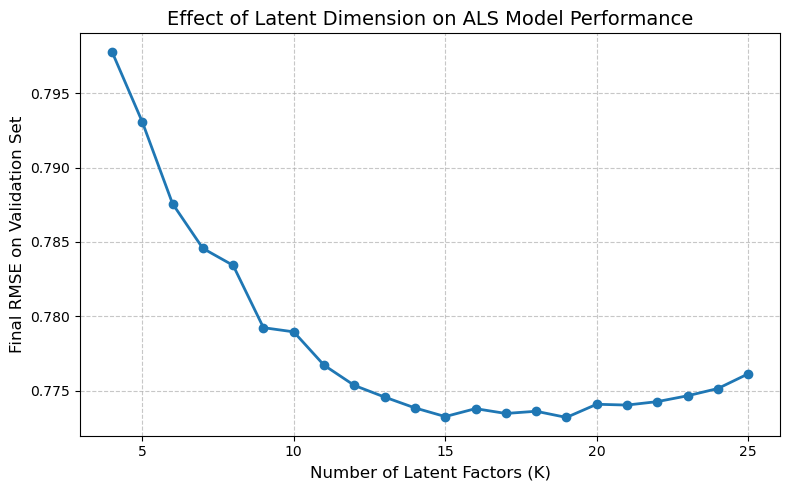

15
0.7731925718353914


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(Ks, Final_RMSEs, marker='o', linewidth=2, markersize=6)
plt.title(
    "Effect of Latent Dimension on ALS Model Performance", fontsize=14
)
plt.xlabel("Number of Latent Factors (K)", fontsize=12)
plt.ylabel("Final RMSE on Validation Set", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(np.argmin(Final_RMSEs))
print(np.min(Final_RMSEs))

In [ ]:
lam = 0.017684422019387584
gamma = 0.06224262766516858
tau = 0.29037492246228525

k = 15

user_bias = np.zeros((n_users))
item_bias = np.zeros((n_items))
user_embedding = np.random.normal(scale=0.1, size=(n_users, k))
item_embedding = np.random.normal(scale=0.1, size=(n_items, k))
feature_embedding = np.random.normal(scale=0.11, size=(n_features, k))
mu_train = train_data[:, 2].mean()

nll = 0
nll_history = []
train_rmse_history = []
test_rmse_history = []
iterations = 3

for iteration in range(iterations):
    # user bias update
    user_bias = Parallel(n_jobs=-1)(
        delayed(update_user_bias)(
            user,
            mu_train,
            data_by_user_train,
            lam,
            gamma,
            tau,
            item_bias,
            user_bias,
            item_embedding,
            user_embedding,
        )
        for user in range(n_users)
    )
    user_bias = np.array(user_bias)

    # user embedding update
    user_embedding = Parallel(n_jobs=-1)(
        delayed(update_user_embedding)(
            user,
            mu_train,
            data_by_user_train,
            lam,
            gamma,
            tau,
            item_bias,
            user_bias,
            item_embedding,
            user_embedding,
        )
        for user in range(n_users)
    )
    user_embedding = np.vstack(user_embedding)

    # item bias update
    item_bias = Parallel(n_jobs=-1)(
        delayed(update_item_bias)(
            item,
            mu_train,
            data_by_movie_train,
            lam,
            gamma,
            tau,
            item_bias,
            user_bias,
            item_embedding,
            user_embedding,
        )
        for item in range(n_items)
    )
    item_bias = np.array(item_bias)

    # item embedding update
    item_embedding = Parallel(n_jobs=-1)(
        delayed(update_item_embedding)(
            item,
            mu_train,
            data_by_movie_train,
            lam,
            gamma,
            tau,
            item_bias,
            user_bias,
            item_embedding,
            user_embedding,
            item_features,
            feature_embedding,
        )
        for item in range(n_items)
    )
    item_embedding = np.vstack(item_embedding)

    # feature embedding update
    feature_embedding = update_feature_embedding(
        item_features, item_embedding, tau, lam=lam
    )

    # compute train RMSE
    uv_train = np.sum(
        user_embedding[train_coo.row] * item_embedding[train_coo.col], axis=1
    )
    pred_train = user_bias[train_coo.row] + item_bias[train_coo.col] + uv_train + mu_train
    diff_train = train_coo.data - pred_train
    squared_error = np.sum(diff_train**2)

    reg_user_bias = np.sum(user_bias**2)
    reg_item_bias = np.sum(item_bias**2)
    reg_user_emb = np.sum(user_embedding**2)

    reg_item_feature = 0.0
    for n in range(n_items):
        feats = item_features[n]
        F_n = np.sum(feats)
        s_n = np.zeros(k) if F_n == 0 else (feats @ feature_embedding) / np.sqrt(F_n)
        reg_item_feature += np.sum((item_embedding[n] - s_n) ** 2)

    reg_feature_emb = np.sum(feature_embedding**2)

    nll = (
        (lam / 2) * squared_error
        + (gamma / 2) * (reg_user_bias + reg_item_bias)
        + (tau / 2) * (reg_user_emb + reg_item_feature + reg_feature_emb)
    )
    nll_history.append(nll)

    train_rmse = np.sqrt(squared_error / len(train_coo.data))
    train_rmse_history.append(train_rmse)

    # compute test RMSE
    uv_test = np.sum(user_embedding[test_coo.row] * item_embedding[test_coo.col], axis=1)
    pred_test = user_bias[test_coo.row] + item_bias[test_coo.col] + uv_test + mu_train
    diff_test = test_coo.data - pred_test
    test_rmse = np.sqrt(np.sum(diff_test**2) / len(test_coo.data))
    test_rmse_history.append(test_rmse)

    print(
        f"Iteration {iteration + 1}, NLL = {nll:.4f}, "
        f"Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}"
    )

C:\Users\gmedw\AppData\Local\Temp\ipykernel_24872\1604762600.py:93: RuntimeWarning: divide by zero encountered in divide
  scaling = np.where(F_n > 0, 1.0 / np.sqrt(F_n), 0.0)


Iteration 1, NLL = 161672.7987, Train RMSE = 0.8335, Test RMSE = 0.8717


In [ ]:
# np.savez("all_data.npz",
#          user_bias=user_bias,
#          item_bias=item_bias,
#          user_embedding=user_embedding,
#          item_embedding=item_embedding,
#          feature_embedding=feature_embedding,
#          nll_history=nll_history,
#          train_rmse_history=train_rmse_history,
#          test_rmse_history=test_rmse_history,
#          item_id_map=item_id_map)